Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [1]:
import matplotlib.pyplot as plt
from random import random
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA
import itertools

import warnings

from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0,1])

In [4]:
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,2020-08-08 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,2020-08-08 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,2020-08-08 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,2020-08-08 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,2020-08-08 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [5]:
df_m = df.resample('M').mean()

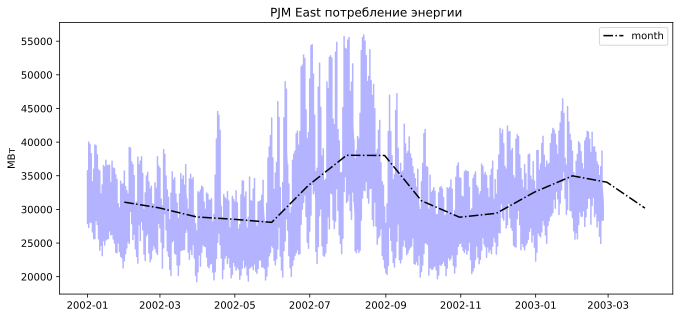

In [6]:
plt.figure(figsize =(11,5))
plt.plot(df.index[:5*24*7*4*3], df.PJME_MW.values[:5*24*7*4*3], 'b',alpha =0.3)
plt.plot(df_m.index[:5*3], df_m.PJME_MW.values[:5*3], '-.k',label='month')
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

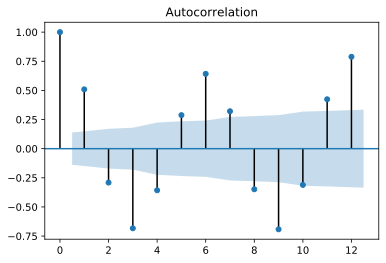

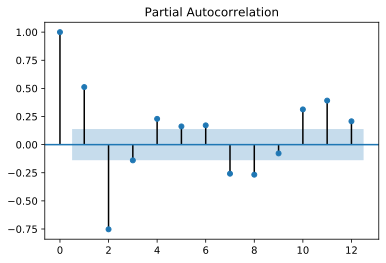

In [7]:
sm.graphics.tsa.plot_acf(df_m.PJME_MW.values, lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(df_m.PJME_MW.values, lags=12)
plt.show()

In [8]:
q = 2
p = 1
d = 2
pdq = [p, d, q]

qs = 1
ps = 0
ds = 1
seasonal_pdq = [ps, ds, qs, 12] 

In [9]:
model = sm.tsa.statespace.SARIMAX(df_m.PJME_MW.values[:-12], 
                                  order=pdq, 
                                  seasonal_order=seasonal_pdq,
                                  enforce_stationarity= False,
                                  enforce_invertibility=False)

In [10]:
results = model.fit()

In [11]:
print(results.summary().tables[0],results.summary().tables[1])

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood               -1425.036
Date:                              Sat, 08 Aug 2020   AIC                           2860.072
Time:                                      12:05:37   BIC                           2875.416
Sample:                                           0   HQIC                          2866.303
                                              - 188                                         
Covariance Type:                                opg                                         
============================================================================================ ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

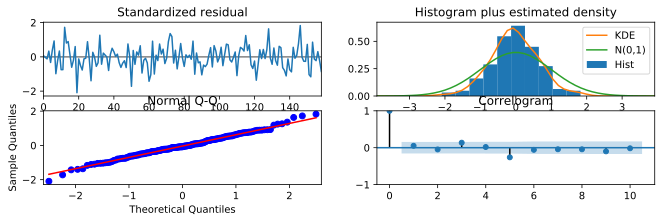

In [12]:
results.plot_diagnostics(figsize=(11, 3))
plt.show()

Подберите параметры модели SARIMAX для этого ряда.

In [13]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 26) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 26)
SARIMAX: (0, 0, 1) x (0, 0, 2, 26)
SARIMAX: (0, 0, 2) x (0, 1, 0, 26)
SARIMAX: (0, 0, 2) x (0, 1, 1, 26)


warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_m.PJME_MW.values[:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [14]:
order=[0,0,0]
seasonal_order=[1,2,2,26]

model = sm.tsa.statespace.SARIMAX(df_m.PJME_MW.values[:-12],order=order,
                                  seasonal_order=seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results_opt = model.fit()
print(f'AIC:{results_opt.aic}')

/home/janecalm/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


AIC:1720.3160513259602


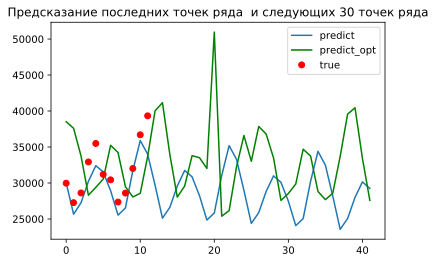

In [15]:
pred_dynamic = results.forecast(42)  
pred_dynamic_opt = results_opt.forecast(42)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
plt.plot(df_m.PJME_MW.values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [16]:
adf_test = sm.tsa.stattools.adfuller(results_opt.resid)
print(adf_test)

(-3.3285688912531746, 0.013648751560261187, 13, 174, {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.57570415906989}, 3460.0534065031848)


3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Чем больше интервал, тем ниже информационный критерий Акаике.

Возмите вариант 1 или 2

            Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
            Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках )
Оцените результат моделирования


Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

In [17]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [18]:
brent_data_W= brent_data.resample('W').mean()

In [19]:
brent_data_W.describe()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
count,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.00000,469.000000,469.000000,469.000000,469.000000
mean,80.712938,2014.668799,6.534790,15.769225,2.510448,183.502452,26.54371,2.517662,0.027505,0.027150,0.030419
std,26.661299,2.627031,3.410980,7.038383,1.105197,104.223962,15.04838,0.316618,0.063859,0.064381,0.068258
min,28.690000,2010.000000,1.000000,3.000000,1.000000,4.200000,1.00000,1.500000,0.000000,0.000000,0.000000
25%,56.206000,2012.000000,4.000000,9.666667,2.000000,93.666667,14.00000,2.500000,0.000000,0.000000,0.000000
50%,76.601667,2015.000000,6.833333,16.000000,2.800000,183.666667,27.00000,2.666667,0.000000,0.000000,0.000000
75%,108.114000,2017.000000,9.333333,22.000000,3.333333,272.666667,39.00000,2.666667,0.000000,0.000000,0.000000
max,125.006667,2019.000000,12.000000,29.500000,4.000000,363.500000,53.00000,4.333333,0.200000,0.250000,0.250000


Text(0.5, 0, 't')

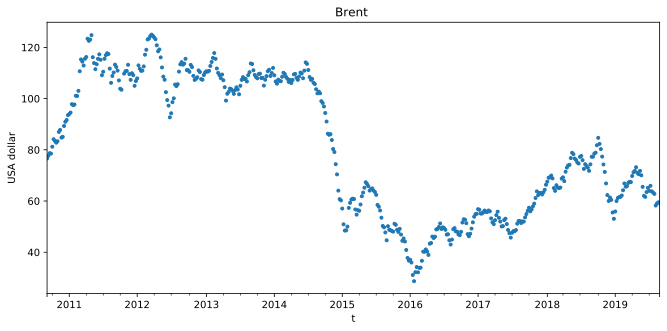

In [20]:
_ = brent_data_W['Значение'].plot( style='.', figsize=( 11, 5 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

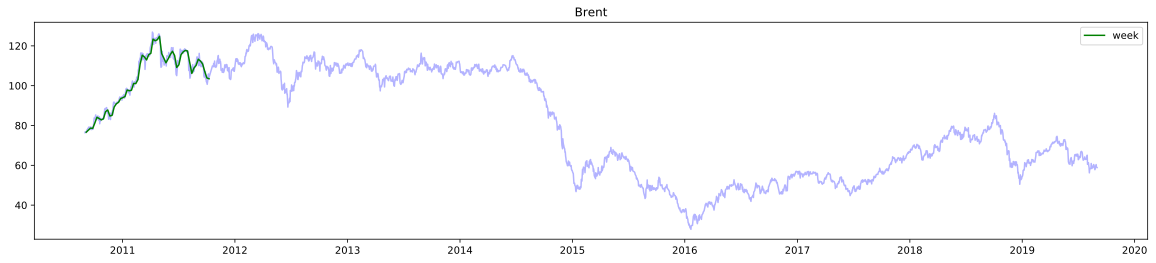

In [21]:
plt.figure(figsize =(20,4))
plt.plot( brent_data.index[:5*24*7*4*3], brent_data['Значение'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( brent_data_W.index[:5*4*3], brent_data_W['Значение'].values[:5*4*3], 'g',label='week'  )
plt.title('Brent' )
plt.legend()
plt.show()

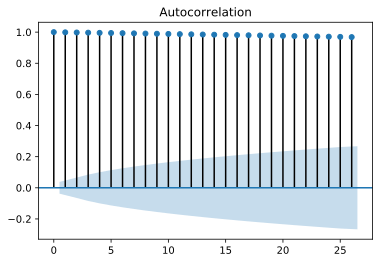

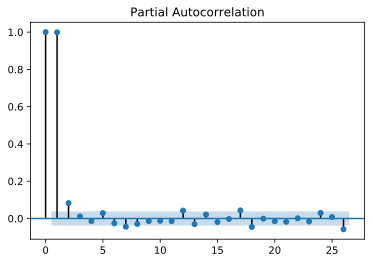

In [22]:
sm.graphics.tsa.plot_acf(brent_data['Значение'].values, lags=26)
plt.show()

sm.graphics.tsa.plot_pacf(brent_data['Значение'].values, lags=26
                         )
plt.show()

In [23]:
import warnings

# Определим p, d и q 
q = 1
p = 1
d = 1
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с недельными данными, тогда сезонность это 26 недель
qs = 1
ps = 1
ds = 1
seasonal_pdq = [ps, ds, qs ,26] 


In [24]:
#для построения модели используем все данные, кроме 12-х последних недель (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(brent_data_W['Значение'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))


SARIMAX[1, 1, 1]x[1, 1, 1, 26] - AIC:1813.3220996398063


In [25]:
print(results.summary().tables[0],results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  458
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 26)   Log Likelihood                -901.661
Date:                            Sat, 08 Aug 2020   AIC                           1813.322
Time:                                    12:05:45   BIC                           1833.317
Sample:                                         0   HQIC                          1821.238
                                            - 458                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

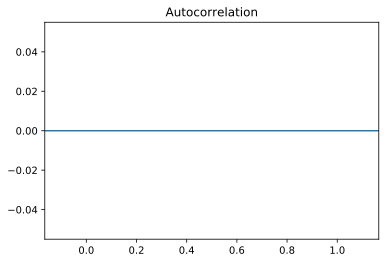

In [26]:
sm.graphics.tsa.plot_acf(results.resid, lags=26)
plt.show()

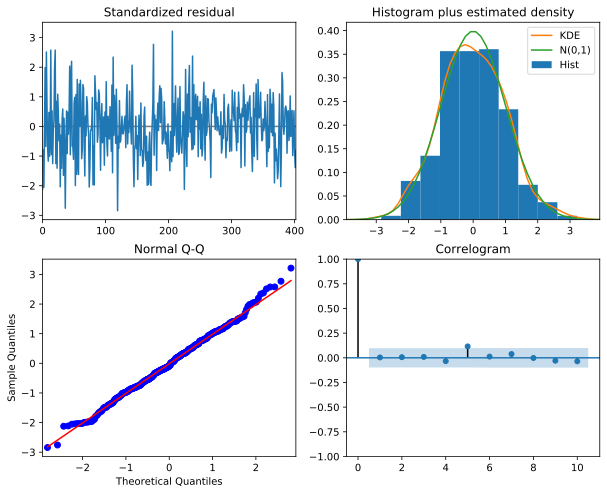

In [27]:
results.plot_diagnostics(figsize=(10, 8))
plt.show()


In [28]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 26) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 26)
SARIMAX: (0, 0, 1) x (0, 0, 2, 26)
SARIMAX: (0, 0, 2) x (0, 1, 0, 26)
SARIMAX: (0, 0, 2) x (0, 1, 1, 26)


In [29]:
import itertools
# Определим p, d и q в диапазоне 0-3
d = [0,1]
p = [0,1] 
q = range(3, 7)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_b = sm.tsa.statespace.SARIMAX(np.log(brent_data_W['Значение'].values[:-30]),
                                          order=param,seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results_ = mod_b.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 3)x[0, 0, 0, 0] - AIC:-696.3241216496903
ARIMA(0, 0, 4)x[0, 0, 0, 0] - AIC:-1236.939465006898
ARIMA(0, 0, 5)x[0, 0, 0, 0] - AIC:-1172.2710297618582
ARIMA(0, 0, 6)x[0, 0, 0, 0] - AIC:-1266.8152733812885
ARIMA(0, 1, 3)x[0, 0, 0, 0] - AIC:-1779.5660759686548
ARIMA(0, 1, 4)x[0, 0, 0, 0] - AIC:-1772.669547992214
ARIMA(0, 1, 5)x[0, 0, 0, 0] - AIC:-1767.707132753831
ARIMA(0, 1, 6)x[0, 0, 0, 0] - AIC:-1764.4637783595983
ARIMA(1, 0, 3)x[0, 0, 0, 0] - AIC:-1785.1503015760022
ARIMA(1, 0, 4)x[0, 0, 0, 0] - AIC:-1777.9435134023838
ARIMA(1, 0, 5)x[0, 0, 0, 0] - AIC:-1774.2108249510284
ARIMA(1, 0, 6)x[0, 0, 0, 0] - AIC:-1771.0954860843951
ARIMA(1, 1, 3)x[0, 0, 0, 0] - AIC:-1778.1330857397843
ARIMA(1, 1, 4)x[0, 0, 0, 0] - AIC:-1771.104512708504
ARIMA(1, 1, 5)x[0, 0, 0, 0] - AIC:-1768.175927847271
ARIMA(1, 1, 6)x[0, 0, 0, 0] - AIC:-1762.4687877051244


In [30]:
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(brent_data_W['Значение'].values[:-12],order=[1,1,1],
                                seasonal_order=[0,0,0,0] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 1975.0822597110505
